Feature: Sensitivity Mapping
============================

Bayesian model comparison allows us to take a dataset, fit it with multiple models and use the Bayesian evidence to
quantify which model objectively gives the best-fit following the principles of Occam's Razor.

However, a complex model may not be favoured by model comparison not because it is the 'wrong' model, but simply
because the dataset being fitted is not of a sufficient quality for the more complex model to be favoured. Sensitivity
mapping allows us to address what quality of data would be needed for the more complex model to be favoured or
alternatively for what sets of model parameter values it would be favoured for data of a given quality.

In order to do this, sensitivity mapping involves us writing a function that uses the model(s) to simulate a dataset.
We then use this function to simulate many datasets, for many different models, and fit each dataset using the same
model-fitting procedure we used to perform Bayesian model comparison. This allows us to infer how much of a Bayesian
evidence increase we should expect for datasets of varying quality and / or models with different parameters.

For strong lensing, this process is crucial for dark matter substructure detection, as discussed in the following paper:

https://arxiv.org/abs/0903.4752

In substructure detection, we scan a strong lens dark matter subhalos by fitting a lens models which include a subhalo.
This tells us whether we successfully did detect a subhalo, but it does not tell us where a subhalo has to be located
(in relation to the source light) to be detectable, nor does to what masses of subhalo we could actually have made a
detection.

To answer these questions, we must perform sensitivity mapping, where we simulate many thousands of strong lens datasets,
each of which include a dark matter subhalo at a given (y,x) coordinate at a given mass. We then fit each dataset twice,
once with a lens model which does not include a subhalo and once with a lens model that does. If the Bayesian evidence
of the model which includes a subhalo is higher than that which does not, then it means a subhalo was detectable!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load the `Interferometer` data, define the visibility and real-space masks and plot them.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:178: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


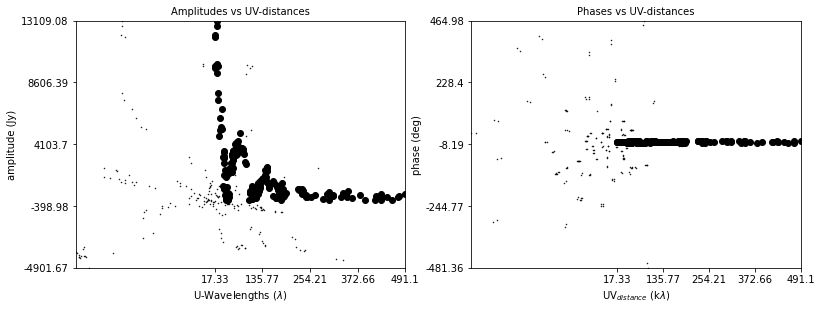

In [2]:
real_space_mask = al.Mask2D.circular(
    shape_native=(151, 151), pixel_scales=0.05, radius=3.0
)

dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    real_space_mask=real_space_mask,
)
interferometer = interferometer.apply_settings(
    settings=al.SettingsInterferometer(transformer_class=al.TransformerNUFFT)
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()


We are going to perform sensitivity mapping to determine where a subhalo is detectable. This will require us to simulate 
many realizations of our dataset with a lens model, called the `simulation_instance`. To get this model, we therefore 
fit the data before performing sensitivity mapping so that we can set the `simulation_instance` as the maximum 
likelihood model.

We perform this fit using the lens model we will use to perform sensitivity mapping, which we call the `base_model`.

In [3]:
base_model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic),
    )
)

search_base = af.DynestyStatic(
    path_prefix=path.join("interferometer", "misc"),
    name="sensitivity_mapping_base",
    unique_tag=dataset_name,
    nlive=50,
)

analysis = al.AnalysisInterferometer(dataset=interferometer)

result = search_base.fit(model=base_model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 15:39:19,846 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 18.85it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
2021-05-10 15:39:19,969 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:39:20,087 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:39:20,190 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


We now define the `base_model` that we use to perform sensitivity mapping. This is the lens model that is fitted to 
every simulated strong lens without a subhalo, giving us the Bayesian evidence which we compare to the model which 
includes one!). 

For this model, we can use the `base_model` above, however we will use the result of fitting this model to the dataset
before sensitivity mapping. This ensures the priors associated with each parameter are initialized so as to speed up
each non-linear search performed during sensitivity mapping.

In [4]:
base_model = result.model

We now define the `perturbation_model`, which is the model component whose parameters we iterate over to perform 
sensitivity mapping. In this case, this model is a `SphNFWMCRLudlow` model and we will iterate over its
`centre` and `mass_at_200`. We set it up as a `Model` so it has an associated redshift and can be directly
passed to the tracer in the simulate function below.

Many instances of the `perturbation_model` are created and used to simulate the many strong lens datasets that we fit. 
However, it is only included in half of the model-fits; corresponding to the lens models which include a dark matter 
subhalo and whose Bayesian evidence we compare to the simpler model-fits consisting of just the `base_model` to 
determine if the subhalo was detectable.

By fitting both models to every simulated lens, we therefore infer the Bayesian evidence of every model to every 
dataset. Sensitivity mapping therefore maps out for what values of `centre` and `mass_at_200` in the dark matter 
subhalo the model-fit including a subhalo provide higher values of Bayesian evidence than the simpler model-fit (and
therefore when it is detectable!).

In [5]:
perturbation_model = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.SphNFWMCRLudlow)

Sensitivity mapping is typically performed over a large range of parameters. However, to make this demonstration quick
and clear we are going to fix the `centre` of the subhalo to a value near the Einstein ring of (1.6, 0.0). We will 
iterate over just two `mass_at_200` values corresponding to subhalos of mass 1e6 and 1e13, of which only the latter
will be shown to be detectable.

In [6]:
perturbation_model.mass.centre.centre_0 = 1.6
perturbation_model.mass.centre.centre_1 = 0.0
perturbation_model.mass.redshift_object = 0.5
perturbation_model.mass.redshift_source = 1.0
perturbation_model.mass.mass_at_200 = af.LogUniformPrior(
    lower_limit=1e6, upper_limit=1e13
)

We are going to perform sensitivity mapping to determine where a subhalo is detectable. This will require us to 
simulate many realizations of our dataset with a lens model, called the `simulation_instance`. This model uses the
result of the fit above.

In [7]:
simulation_instance = result.instance

We now write the `simulate_function`, which takes the `simulation_instance` of our model (defined above) and uses it to 
simulate a dataset which is subsequently fitted.

Note that when this dataset is simulated, the quantity `instance.perturbation` is used in the `simulate_function`.
This is an instance of the `SphNFWMCRLudlow`, and it is different every time the `simulate_function` is called
based on the value of sensitivity being computed. 

In this example, this `instance.perturbation` corresponds to two different subhalos with values of `mass_at_200` of 
1e6 MSun and 1e13 MSun.

In [8]:


def simulate_function(instance):

    """
    Set up the `Tracer` which is used to simulate the strong lens interferometer, which may include the subhalo in
    addition to the lens and source galaxy.
    """
    tracer = al.Tracer.from_galaxies(
        galaxies=[
            instance.galaxies.lens,
            instance.perturbation,
            instance.galaxies.source,
        ]
    )

    """
    Set up the grid, uv_wavelengths and simulator settings used to simulate interferometer dataset of the strong lens.
    These should be tuned to match the S/N and noise properties of the observed data you are performing sensitivity 
    mapping on.
    """
    grid = al.Grid2DIterate.uniform(
        shape_native=real_space_mask.shape_native,
        pixel_scales=real_space_mask.pixel_scales,
        fractional_accuracy=0.9999,
        sub_steps=[2, 4, 8, 16, 24],
    )

    simulator = al.SimulatorInterferometer(
        uv_wavelengths=interferometer.uv_wavelengths,
        exposure_time=300.0,
        background_sky_level=0.1,
        noise_sigma=0.1,
        transformer_class=al.TransformerNUFFT,
    )

    simulated_interferometer = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

    """
    The data generated by the simulate function is that which is fitted, so we should apply the mask for the analysis 
    here before we return the simulated data.
    """
    return al.Interferometer(
        visibilities=simulated_interferometer.visibilities,
        noise_map=simulated_interferometer.noise_map,
        uv_wavelengths=simulated_interferometer.uv_wavelengths,
        real_space_mask=real_space_mask,
    )


Each model-fit performed by sensitivity mapping creates a new instance of an `Analysis` class, which contains the
data simulated by the `simulate_function` for that model.

This requires us to write a wrapper around the PyAutoLens `Analysis` class.

In [9]:
from astropy import cosmology as cosmo


class AnalysisInterferometerSensitivity(al.AnalysisInterferometer):
    def __init__(self, dataset):

        super().__init__(dataset=dataset)


We next specify the search used to perform each model fit by the sensitivity mapper.

In [10]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer", "misc"),
    name="sensitivity_mapping",
    unique_tag=dataset_name,
    nlive=50,
)

We can now combine all of the objects created above and perform sensitivity mapping. The inputs to the `Sensitivity`
object below are:

- `simulation_instance`: This is an instance of the model used to simulate every dataset that is fitted. In this example 
it is a lens model that does not include a subhalo, which was inferred by fitting the dataset we perform sensitivity 
mapping on.

- `base_model`: This is the lens model that is fitted to every simulated dataset, which does not include a subhalo. In 
this example is composed of an `EllIsothermal` lens and `EllSersic` source.

- `perturbation_model`: This is the extra model component that alongside the `base_model` is fitted to every simulated 
dataset. In this example it is a `SphNFWMCRLudlow` dark matter subhalo.

- `simulate_function`: This is the function that uses the `simulation_instance` and many instances of the `perturbation_model` 
to simulate many datasets that are fitted with the `base_model` and `base_model` + `perturbation_model`.

- `analysis_class`: The wrapper `Analysis` class that passes each simulated dataset to the `Analysis` class that fits 
the data.

- `number_of_steps`: The number of steps over which the parameters in the `perturbation_model` are iterated. In this 
example, `mass_at_200` has a `LogUniformPrior` with lower limit 1e6 and upper limit 1e13, therefore 
the `number_of_steps` of 2 will simulate and fit just 2 datasets where the `mass_at_200` is between 1e6 and 1e13.

- `number_of_cores`: The number of cores over which the sensitivity mapping is performed, enabling parallel processing
if set above 1.

In [11]:
from autofit.non_linear.grid import sensitivity as s

sensitivity = s.Sensitivity(
    search=search,
    simulation_instance=simulation_instance,
    base_model=base_model,
    perturbation_model=perturbation_model,
    simulate_function=simulate_function,
    analysis_class=AnalysisInterferometerSensitivity,
    number_of_steps=2,
    number_of_cores=2,
)

sensitivity_result = sensitivity.run()

2021-05-10 15:39:20,817 - root - INFO - created process 0
2021-05-10 15:39:20,827 - root - WARNING - Both model and search should be set
2021-05-10 15:39:23,845 - root - WARNING - Both model and search should be set
2021-05-10 15:39:25,697 - root - INFO - starting process 0
2021-05-10 15:39:25,861 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 56.86it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
2021-05-10 15:39:25,920 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:39:26,042 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:39:26,148 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:39:26,517 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it 

You should now look at the results of the sensitivity mapping in the folder `output/features/sensitivity_mapping`. 

You will note the following 4 model-fits have been performed:

 - The `base_model` is fitted to a simulated dataset where a subhalo with `mass_at_200=1e6` is included.

 - The `base_model` + `perturbation_model` is fitted to a simulated dataset where a subhalo with `mass_at_200=1e6` 
 is included.

 - The `base_model` is fitted to a simulated dataset where a subhalo with `mass_at_200=1e13` is included.

 - The `base_model` + `perturbation_model` is fitted to a simulated dataset where a subhalo with `mass_at_200=1e13` is 
 included.

The fit produces a `sensitivity_result`. 

We are still developing the `SensitivityResult` class to provide a data structure that better streamlines the analysis
of results. If you intend to use sensitivity mapping, the best way to interpret the resutls is currently via
**PyAutoFit**'s database and `Aggregator` tools. 

In [12]:
print(sensitivity_result.results[0].result.samples.log_evidence)
print(sensitivity_result.results[1].result.samples.log_evidence)

-2864977357.0927887
-149667468017.83636


Finish.